In [1]:
import os
import zipfile
import subprocess
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import Image, display

There are 123 images of dogs
There are 123 images of cats
There are 116 images of birds


Sample cat image:


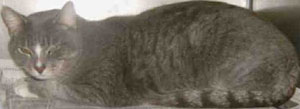


Sample dog image:


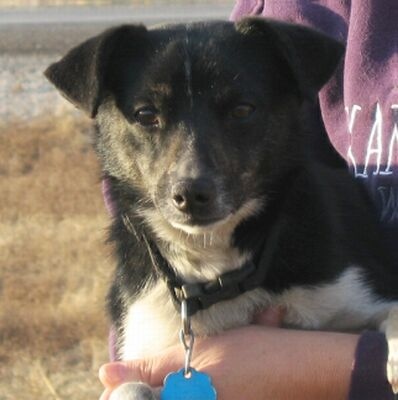


Sample bird image:


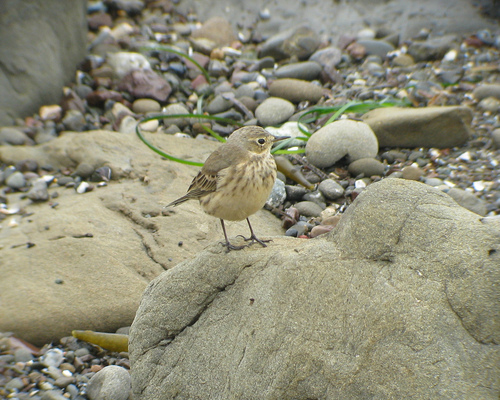

In [2]:
!wget -q https://storage.googleapis.com/mlep-public/course_3/week2/images.zip

base_dir = '/tmp/data'

with zipfile.ZipFile('/content/images.zip', 'r') as my_zip:
  my_zip.extractall(base_dir)

dogs_dir = os.path.join(base_dir, 'images/dogs')
cats_dir = os.path.join(base_dir,'images/cats')
birds_dir = os.path.join(base_dir,'images/birds')

print(f"There are {len(os.listdir(dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(cats_dir))} images of cats")
print(f"There are {len(os.listdir(birds_dir))} images of birds\n\n")

print("Sample cat image:")
display(Image(filename=f"{os.path.join(cats_dir, os.listdir(cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(dogs_dir, os.listdir(dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(birds_dir, os.listdir(birds_dir)[0])}"))

In [3]:
!wget -q -P /content/model/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index

In [4]:
model = tf.keras.models.load_model('/content/model')

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [10]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print(f'export_path = {export_path}\n')


tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = /tmp/1



In [8]:
print(f'\nFiles of model saved in {export_path }:\n')
!ls -lh {export_path}


Files of model saved in /tmp/1:

total 172K
drwxr-xr-x 2 root root 4.0K Jul 14 18:33 assets
-rw-r--r-- 1 root root   55 Jul 14 18:33 fingerprint.pb
-rw-r--r-- 1 root root  24K Jul 14 18:33 keras_metadata.pb
-rw-r--r-- 1 root root 134K Jul 14 18:33 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jul 14 18:33 variables


In [9]:
!saved_model_cli show --dir {export_path} --tag_set serve --signature_def serving_default

2024-07-14 18:34:19.430749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 18:34:19.430827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 18:34:19.432247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 18:34:20.722581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel SignatureDef contains the following input(s):
  inputs['conv2d_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 150, 150, 3)
      name: serving_default_conv2d_input:0
The given SavedModel SignatureDef contai

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/images',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

print(f"labels for each class in the test generator are: {val_gen_no_shuffle.class_indices}")

Found 362 images belonging to 3 classes.
labels for each class in the test generator are: {'birds': 0, 'cats': 1, 'dogs': 2}


In [13]:
data_imgs, labels = next(val_gen_no_shuffle)

print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32,)


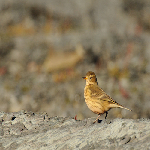

Image shows a bird.



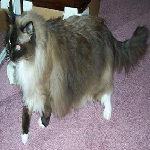

Image shows a cat.



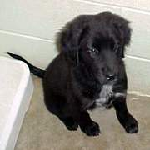

Image shows a dog.



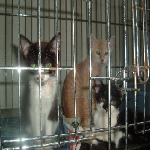

Image shows a cat.



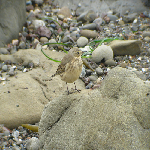

Image shows a bird.



In [14]:
from tensorflow.keras.preprocessing.image import array_to_img

def get_class(index):
  if index == 0:
    return "bird"
  elif index == 1:
    return "cat"
  elif index == 2:
    return "dog"
  return None


def plot_array(array, label, pred=None):
  array = np.squeeze(array)
  img = array_to_img(array)
  display(img)
  if pred is None:
    print(f"Image shows a {get_class(label)}.\n")
  else:
    print(f"Image shows a {get_class(label)}. Model predicted it was {get_class(pred)}.\n")


for i in range(5):
  plot_array(data_imgs[i], labels[i])

In [15]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

--2024-07-14 18:35:29--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 319.88M  81.1MB/s    in 4.2s    

2024-07-14 18:35:33 (75.3 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb’ saved [335421916/335421916]

Selecting previously unselected package tensorflow-model-server-universal.
(Reading database ... 123576 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpa

In [16]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [17]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=animal_classifier \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [18]:
!tail server.log

2024-07-14 18:35:45.745477: E external/org_tensorflow/tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: NOT_FOUND: Op type not registered 'DisableCopyOnRead' in binary running on 3d9dda0cce14. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
	when importing GraphDef to MLIR module in GrapplerHook
2024-07-14 18:35:45.818257: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:630] NodeDef mentions attribute debug_name which is not in the op definition: Op<name=VarHandleOp; signature= -> resource:resource; attr=container:string,default=""; attr=shared_name:string,default=""; attr=dtype:type; attr=shape:shape; attr=allowed_devices:list(string),default=[]; is_stateful=true> This may

In [19]:
import json

data_imgs_list = data_imgs.tolist()

data = json.dumps({"instances": data_imgs_list})

In [20]:
import requests

headers = {"content-type": "application/json"}

json_response = requests.post('http://localhost:8501/v1/models/animal_classifier:predict', data=data, headers=headers)

predictions = json.loads(json_response.text)['predictions']

print(f"predictions has shape: {np.asarray(predictions).shape}")

predictions has shape: (32, 3)


In [21]:
preds = np.argmax(predictions, axis=1)

print(f"preds has shape: {preds.shape}")

preds has shape: (32,)


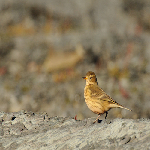

Image shows a bird. Model predicted it was bird.



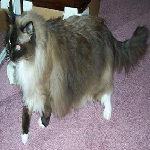

Image shows a cat. Model predicted it was dog.



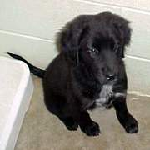

Image shows a dog. Model predicted it was dog.



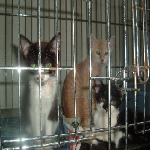

Image shows a cat. Model predicted it was dog.



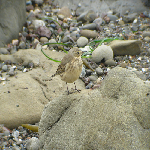

Image shows a bird. Model predicted it was bird.



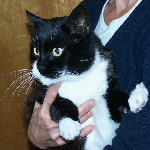

Image shows a cat. Model predicted it was cat.



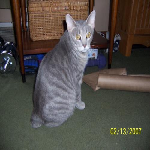

Image shows a cat. Model predicted it was dog.



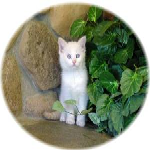

Image shows a cat. Model predicted it was cat.



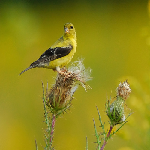

Image shows a bird. Model predicted it was bird.



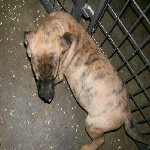

Image shows a dog. Model predicted it was dog.



In [22]:
for i in range(10):
  plot_array(data_imgs[i], labels[i], preds[i])